In [1]:
import matplotlib.pyplot as plt
import numpy as np
import datetime
import os
import pandas as pd
import scipy.spatial as spatial
import cprv1.cprv1 as cpr
import wmf.wmf as wmf
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
%matplotlib inline

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
self = cpr.Nivel(codigo = 93,user = 'sample_user',passwd='s@mple_p@ss',SimuBasin=True)

In [ ]:
lon = self.info.longitud
lat = self.info.latitud

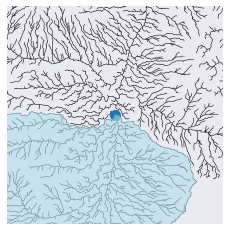

In [11]:
dxp=12.7
add=0.001
add_out=0.07
dt =300
save=False

if dxp == 60:
    umbral = 1000
else:
    umbral = 500

folder_path = '/media/nicolas/maso/Mario/basin_maker'
dem_path = '%s/dem_%s.tif'%(folder_path,int(dxp))
dir_path = '%s/dir_%s.tif'%(folder_path,int(dxp))
nodes_path = '%s/nodes_%s.csv'%(folder_path,int(dxp))
net_path = '%s/net_%s'%(folder_path,int(dxp))
#finding nearest point
llcrnrlat=lat-add;urcrnrlat=lat+add;llcrnrlon=lon-add;urcrnrlon=lon+add
df = pd.read_csv(nodes_path,index_col=0)
bt = df[((df.index.values>(llcrnrlon))&(df.index.values<(urcrnrlon)))&((df['Y']>llcrnrlat)&(df['Y']<urcrnrlat))]
A = map(lambda x,y: [x,y],bt.index,bt.Y.values)
lon_found,lat_found = tuple(A[spatial.KDTree(A).query((lon,lat))[1]])
#plot
fig = plt.figure()
axis =fig.add_subplot(111)
m = Basemap(projection='merc',llcrnrlat=llcrnrlat-add_out,urcrnrlat=urcrnrlat+add_out,
                llcrnrlon=llcrnrlon- add_out,urcrnrlon=urcrnrlon + add_out,resolution='c',ax=axis)
m.readshapefile(net_path,'net')
x,y = m(lon,lat)
x3,y3 = m(lon_found,lat_found)
x2,y2 = m(bt.index.values,bt['Y'].values)
m.scatter(x,y,s=100,zorder = 20)
m.scatter(x2,y2,s=50,color='tan',alpha=0.4)
m.scatter(x3,y3,s=50,color='r')
#setting wmf
wmf.cu.nodata=-9999.0
wmf.cu.dxp=dxp
DEM = wmf.read_map_raster(dem_path,True)
DIR = wmf.read_map_raster(dir_path,True)
DIR[DIR<=0] = wmf.cu.nodata.astype(int)
DIR = wmf.cu.dir_reclass_rwatershed(DIR,wmf.cu.ncols,wmf.cu.nrows)
st = wmf.Stream(lon_found,lat_found,DEM,DIR,name = 'Stream%s'%self.info.slug)
cu = wmf.SimuBasin(lon_found,lat_found, DEM, DIR,name='Basin%s'%self.codigo, dt = dt, umbral=umbral, stream=st)
rute_shapes = '/media/nicolas/maso/Mario/shapes'
paths = {'stream_path':'%s/stream/%s'%(rute_shapes,self.codigo),
        'net_path' : '%s/net/%s/'%(rute_shapes,self.codigo),
        'polygon_path' : '%s/polygon/%s'%(rute_shapes,self.codigo)}

nc_path = '/media/nicolas/maso/Mario/basins/%s.nc'%self.codigo
for path in paths.values():
    os.system('mkdir %s'%path)

st.Save_Stream2Map(paths['stream_path']+'/%s.shp'%self.codigo)
cu.Save_Net2Map(paths['net_path']+'/%s.shp'%self.codigo)
cu.set_Geomorphology()
cu.GetGeo_Cell_Basics()
cu.GetGeo_Parameters()
cu.Save_Basin2Map(paths['polygon_path']+'/%s.shp'%self.codigo,dx=dxp)
cu.Save_SimuBasin(nc_path,ruta_dem = dem_path,ruta_dir = dir_path)
m.readshapefile(paths['polygon_path']+'/%s'%self.codigo,'basin',zorder=30,color='w')
patches = []
for info, shape in zip(m.basin, m.basin):
    patches.append( Polygon(np.array(shape), True))
    axis.add_collection(PatchCollection(patches, facecolor= self.colores_siata[0], edgecolor=self.colores_siata[6], linewidths=0.5, zorder=30,alpha=0.6))


In [12]:
%matplotlib inline

201803261330-201803261630-93-sample_user
/media/nicolas/maso/Mario/user_output/radar/201803261330-201803261630-93-sample_user
201803261330-201803261630-93-sample_user


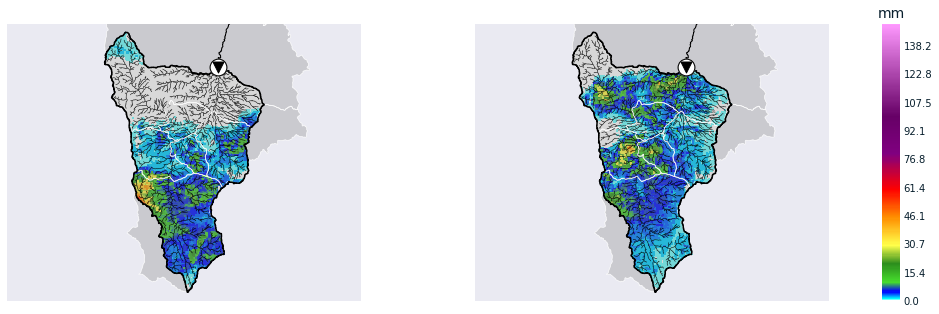

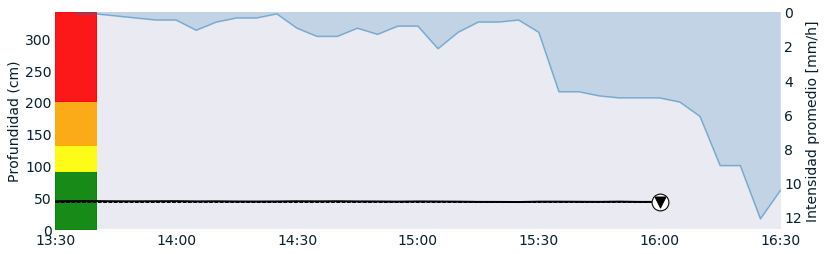

In [4]:
self.rain_report('2018-03-26 16:00')